# **1. Using Tensorflow**

**a. Libraries import**

In [30]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

**b. Dataset display**

This part will enable us to have an insight on the dataset

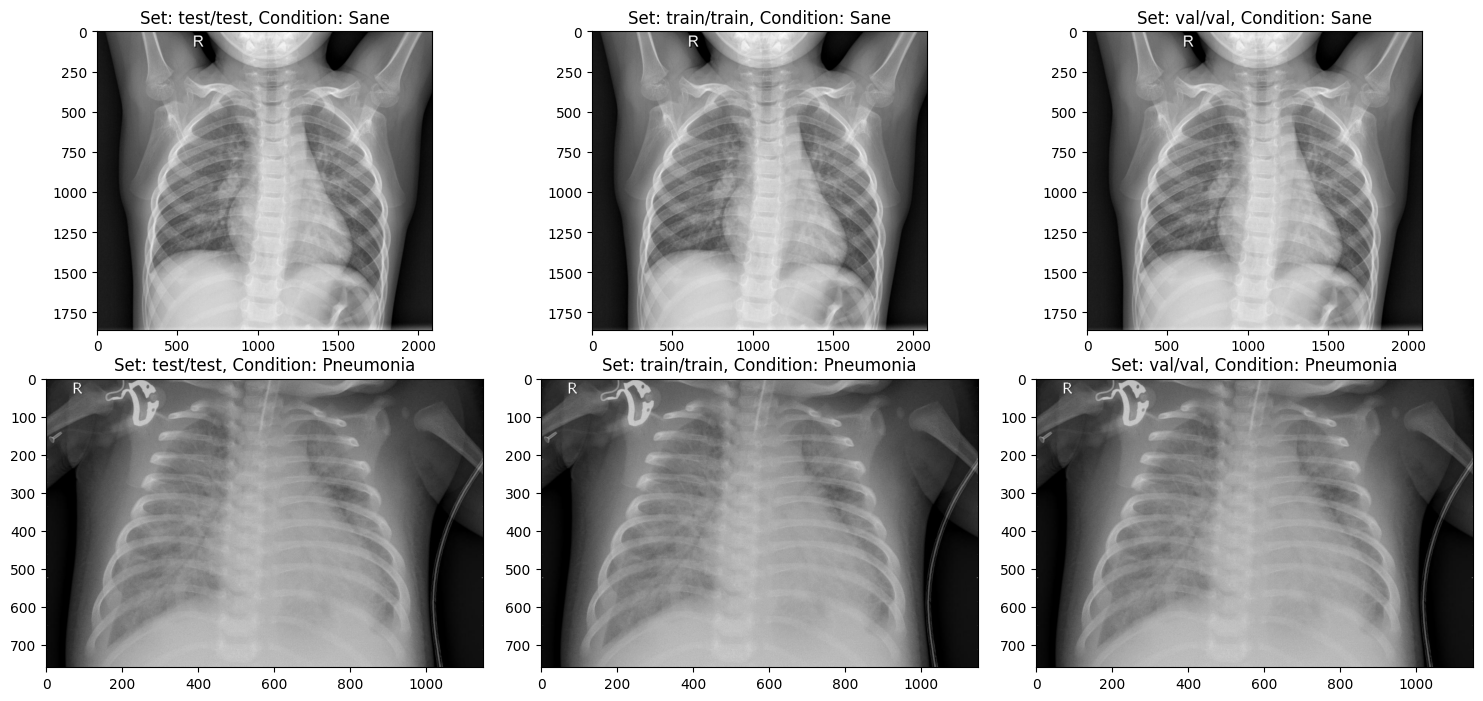

In [17]:
import os
import matplotlib.pyplot as plt
input_path= r'C:\Users\fiche\OneDrive\Bureau\chest_Xray'
# input_path = 'drive/MyDrive/chest_xray'

dataset_names = ['test/test', 'train/train', 'val/val']

fig, ax = plt.subplots(2, len(dataset_names), figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, dataset_name in enumerate(dataset_names):
    pneumonia_image_dir = r'C:\Users\fiche\OneDrive\Bureau\chest_Xray\train\PNEUMONIA'
    normal_image_dir = r'C:\Users\fiche\OneDrive\Bureau\chest_Xray\train\NORMAL'

    # Check if the directories exist and contain files
    if os.path.exists(normal_image_dir) and os.path.exists(pneumonia_image_dir):
        normal_images = os.listdir(normal_image_dir)
        pneumonia_images = os.listdir(pneumonia_image_dir)

        # Check if the directories are not empty
        if normal_images and pneumonia_images:
            normal_image_name = normal_images[0]
            pneumonia_image_name = pneumonia_images[0]

            normal_image_path = os.path.join(normal_image_dir, normal_image_name)
            pneumonia_image_path = os.path.join(pneumonia_image_dir, pneumonia_image_name)

            ax[i].imshow(plt.imread(normal_image_path), cmap='gray')
            ax[i].set_title(f'Set: {dataset_name}, Condition: Sane')

            ax[i + len(dataset_names)].imshow(plt.imread(pneumonia_image_path), cmap='gray')
            ax[i + len(dataset_names)].set_title(f'Set: {dataset_name}, Condition: Pneumonia')
        else:
            print(f"Warning: No images found in {dataset_name} directory")
    else:
        print(f"Warning: Directory {normal_image_dir} or {pneumonia_image_dir} does not exist")

plt.show()


We can also see what is the distribution of our images over the 2 categories

In [19]:
for _set in ['/test', '/train', '/val']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('{} set: normal images = {} | pneumonia images = {}'.format(_set, n_normal, n_infect))

/test set: normal images = 234 | pneumonia images = 390
/train set: normal images = 1341 | pneumonia images = 3875
/val set: normal images = 8 | pneumonia images = 8


**C. Data processing**

All our images aren't the same size so we will need to resize them. We also have to load our images with their label (PNEUMONIA/NORMAL)


In [21]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(
    directory=input_path + '/train/train',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path + '/test/test',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

    test_data = []
    test_labels = []
    for status in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/test/test' + status)):
            img = plt.imread(input_path + '/test/test' + status + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if status == '/NORMAL/':
                label = 0
            elif status == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

Setting hyperparameters of our CNN

In [22]:
img_dims = 150
epochs = 50
batch_size = 32
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

NameError: name 'ImageDataGenerator' is not defined

**d. CNN**

In [ ]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# Convulotion 1
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 2
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 3
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 4
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# 5
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Training CNN model

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-38-5446744f9403>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/50
163/163 [==============================] - 1875s 11s/step - loss: 0.3528 - accuracy: 0.8395 - val_loss: 0.6796 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 304s 2s/step - loss: 0.2687 - accuracy: 0.8921 - val_loss: 0.9510 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 312s 2s/step - loss: 0.2487 - accuracy: 0.9045 - val_loss: 2.3660 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 302s 2s/step - loss: 0.2194 - accuracy: 0.9101 - val_loss: 1.2439 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9172
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 310s 2s/step - loss: 0.2120 - accuracy: 0.9172 - val_loss: 0.7341 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 303

**e. Accuracy and loss function**

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[metric])
    ax[i].plot(hist.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['training', 'validation'])

**Confusion matrix and F1-score**

In [ ]:
preds = model.predict(test_data)
acc = accuracy_score(test_labels, np.round(preds)) * 100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
print(cm)

print('\nTEST METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2 * precision * recall / (precision + recall)))

print('\nTRAIN METRIC')
print('Training accuracy: {}%'.format(np.round((hist.history['accuracy'][-1]) * 100)))

# **2. Using PyTorch**

**a. Libraries import**

In [ ]:
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
import pandas as pd
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import numpy as np
from torchsummary import summary
from timeit import default_timer as timer
import os
from PIL import Image
import matplotlib.pyplot as plt

**b. Setting variables**

In [ ]:
batch_size = 24
datadir = 'chest_Xray'
train_dir = datadir + '/train/'
test_dir = datadir + '/test/'
val_dir = datadir + '/val/'
save_file_name = 'vgg16-chest.pt'
checkpoint_path = 'vgg16-chest.pth'
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

**c. Choose between CPU and GPU for training**

In [ ]:
train_on_gpu = cuda.is_available()
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

**d. Load dataset**

In [ ]:
for categorie in os.listdir(train_dir):
    categories.append(categorie)
    train_imgs = os.listdir(train_dir + categorie)
    valid_imgs = os.listdir(val_dir + categorie)
    test_imgs = os.listdir(test_dir + categorie)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))
    for image in train_imgs:
        img_categories.append(image)
        img = Image.open(train_dir + categorie + '/' + image)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).sort_values('category')
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})
n_classes = len(cat_df)

**e. Data insight**

In [ ]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='c', figsize=(10, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')

**f. Data processing**


Here we will do data augmentation on our training images (Rotation/Flip/...) and normalize all images to the Imagenet standard

In [ ]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=val_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

In [ ]:
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

**CNN model**

In [ ]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add our custom layers
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [ ]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())